# Introduction
# Getting Ready for This Homework
# Programming Tasks
## Building Your Own ViT

In [1]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, embedding_size, num_heads):
        super().__init__()
        assert embedding_size%num_heads == 0
        self.embedding_size = embedding_size
        self.num_heads = num_heads
        self.em_frag_size = embedding_size // num_heads
        
        self.norm1 = nn.LayerNorm(embedding_size)
        
        self.WQ = nn.Linear(embedding_size, embedding_size)
        self.WK = nn.Linear(embedding_size, embedding_size)
        self.WV = nn.Linear(embedding_size, embedding_size)
        
        self.soft = nn.Softmax(dim=3)
        self.soft_scale = 1 / torch.sqrt(torch.tensor(self.em_frag_size))
        
        self.ffn = nn.Sequential(
            nn.LayerNorm(embedding_size),
            nn.Linear(embedding_size, embedding_size*2),
            nn.ReLU(inplace=True),
            nn.Linear(embedding_size*2, embedding_size)
        )
        
    
    def forward(self, x):
        x = self.norm1(x)
        
        # get q,k,v vectors, then reshape, cutting up embeddings for each head
        Q = self.WQ(x).view(-1, x.shape[1], self.num_heads, self.em_frag_size)
        K = self.WK(x).view(-1, x.shape[1], self.num_heads, self.em_frag_size)
        V = self.WV(x).view(-1, x.shape[1], self.num_heads, self.em_frag_size)
        
        # multi headed attention - position i means ith element of input sequence
        qk = torch.einsum("nphi,nqhi->nhpq", Q, K)                   # does dot product between position q and p's vectors for head h and batch n
        sqk = self.soft(qk * self.soft_scale)                        # "row-wise" softmax
        newv = torch.einsum("nhsj,njhi->nshi", sqk, V).flatten(2)    # does dot product between position s normalized QK^T row and the value 
                                                                     # vectors (ith element of vector) of head h and batch n 
        
        x = x + newv
        return x + self.ffn(x)
    
class EncoderStack(nn.Module):
    def __init__(self, num_layers, embedding_size, num_heads):
        super().__init__()
        trans_list = list()
        for i in range(num_layers):
            trans_list.append(Encoder(embedding_size, num_heads))
        self.transformers = nn.Sequential(*trans_list)
        self.norm = nn.LayerNorm(embedding_size)
    
    def forward(self, x):
        x = self.transformers(x)
        return self.norm(x)

In [2]:
class ViT(nn.Module):
    def __init__(self, num_classes, embedding_size=128, num_heads=8, num_patches=16, num_layers=4):
        super().__init__()
        self.embedding_size = embedding_size
        self.num_heads = num_heads
        self.num_patches = num_patches
        
        self.conv = nn.Conv2d(3, embedding_size, kernel_size=16, stride=16)
        self.posParam = nn.Parameter(torch.zeros(num_patches+1, embedding_size))
        
        self.transformers = EncoderStack(num_layers, embedding_size, num_heads)
        
        self.mlp_head = nn.Linear(embedding_size, num_classes)
        
        
    def forward(self, x):
        # get patch embeddings
        x = self.conv(x).permute(0, 2, 3, 1).view(-1, self.num_patches, self.embedding_size)
        
        # add pos embedding and [class] token
        zeros = torch.zeros(x.shape[0], 1, self.embedding_size).to(next(self.parameters()).device)
        x = torch.cat((zeros, x), dim=1)
        x = x + self.posParam
        
        x = self.transformers(x)
        return self.mlp_head(x[:, 0, :])

In [3]:
import torch
img = torch.randn(2, 3, 64, 64)
model = ViT(num_classes=3)
print(model(img))

num_params = sum(p.numel() for p in model.parameters())
print("num params", num_params)

tensor([[ 0.7880,  0.4791,  0.1069],
        [-0.3596,  0.8294,  0.1999]], grad_fn=<AddmmBackward0>)
num params 565123


## Image Classification with Your ViT

In [4]:
import os
from PIL import Image
import torchvision.transforms as tvt

cats = ['airplane', 'bus', 'cat', 'dog', 'pizza']

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, augment=True, augment_times=10):
        super().__init__()
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)
        self.augment = augment
        
        transforms = [tvt.ToTensor()]
        if augment:
            self.augment_times = augment_times
            transforms += [
                tvt.ColorJitter(brightness=.2, hue=.1),
                tvt.RandomAffine(10, (.3, .3), (.75,1.25)),
                tvt.RandomPerspective()
            ]
        else:
            self.augment_times = 1
        self.transform = tvt.Compose(transforms)
        
        self.classes = {name: i for i, name in enumerate(cats)}
        
    def __len__(self):
        return len(self.image_files) * self.augment_times
    
    def __getitem__(self, index):
        index = index//self.augment_times
        filename = self.image_files[index]
        label = self.classes[filename.split('_')[0]]
        pic = Image.open(os.path.join(self.root_dir,filename)).convert("RGB")
        img = self.transform(pic)
        return (img, label)

In [5]:
def train_loop(net, dataloader, epochs):
    net.train()
    losses = list()
    device = torch.device('cuda')
    net = net.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9,0.98))
    # epochs = 14
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if (i+1) % 100 == 0:
                losses.append(running_loss / 100)
                running_loss = 0
        print(f"epoch: {epoch}, loss: {losses[-1]}")
    return losses

In [6]:
train_data = MyDataset("../hw4-class/dataset/train", augment=False)
train_dataloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=8, num_workers=4)

net = ViT(num_classes=5, num_layers=4)

In [7]:
import numpy as np
loss_net = train_loop(net, train_dataloader, 14)
torch.save(net.state_dict(), "net.pth")
np.savetxt("train_loss", loss_net)

# net.load_state_dict(torch.load("net_no_augment.pth"))
# loss_net = np.loadtxt("train_loss_no_augment")

epoch: 0, loss: 1.2966212719678878
epoch: 1, loss: 1.2964392340183257
epoch: 2, loss: 1.2139191913604737
epoch: 3, loss: 1.164678624868393
epoch: 4, loss: 1.1443987691402435
epoch: 5, loss: 1.1151140981912613
epoch: 6, loss: 1.0091308662295342
epoch: 7, loss: 0.9685753870010376
epoch: 8, loss: 0.9257455080747604
epoch: 9, loss: 0.8672336953878402
epoch: 10, loss: 0.7788721762597561
epoch: 11, loss: 0.8189209201931953
epoch: 12, loss: 0.7881267395615578
epoch: 13, loss: 0.6370917954295874


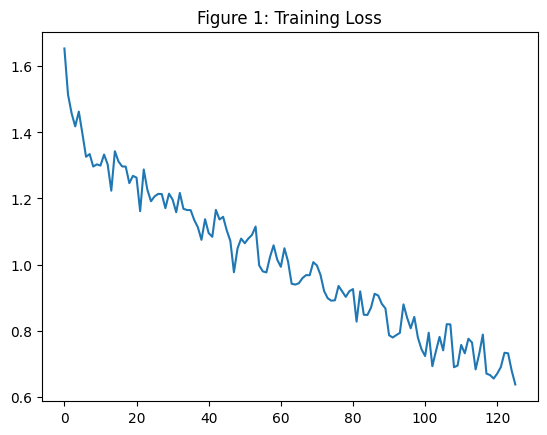

In [8]:
import matplotlib.pyplot as plt 
plt.figure()
plt.plot(loss_net)
plt.title("Figure 1: Training Loss")
plt.show()

In [9]:
val_batch = 10
val_data = MyDataset("../hw4-class/dataset/val", augment=False)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=val_batch, num_workers=2)

In [10]:
def val_loop(net, dataloader):
    net.eval()
    device = torch.device('cuda')
    net.to(device)
    labels = np.zeros(len(dataloader.dataset))
    preds = np.zeros(len(dataloader.dataset))
    with torch.no_grad():
        i = 0
        for data in dataloader:
            imgs, lbls = data
            imgs = imgs.to(device)
            predictions = net(imgs)
            predictions = np.argmax(predictions.cpu().numpy(), axis=1)
            num = predictions.shape[0]
            preds[i:i+num] = predictions
            labels[i:i+num] = lbls.numpy()
            i += num
    return preds, labels

In [11]:
val_train_data = MyDataset("../hw4-class/dataset/train", augment=False)
val_train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=10, num_workers=2)

In [12]:
pred_train, lab_train = val_loop(net, val_train_dataloader)

In [13]:
pred, lab = val_loop(net, val_dataloader)

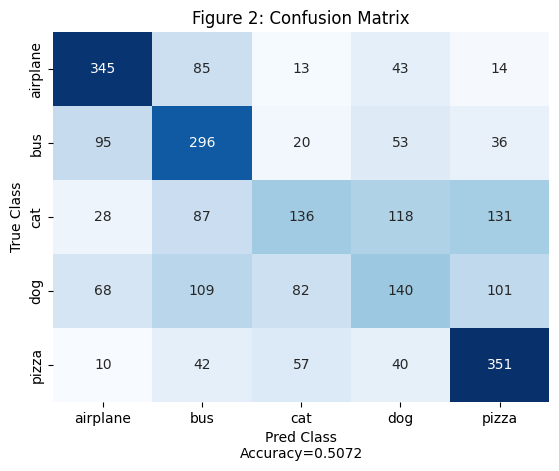

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def confusion_plot(lab, pred, num):
    plt.figure()
    accuracy = np.sum(pred == lab) / len(pred)
    conf1 = confusion_matrix(lab, pred)
    conf1 = pd.DataFrame(data = conf1, index=cats, columns=cats)
    ax1 = sns.heatmap(conf1, annot=True, cmap="Blues", fmt="d", cbar=False)
    ax1.set_title(f"Figure {num}: Confusion Matrix")
    ax1.set_ylabel("True Class")
    ax1.set_xlabel(f"Pred Class\nAccuracy={accuracy}")
    return ax1

confusion_plot(lab, pred, 2)
plt.show()

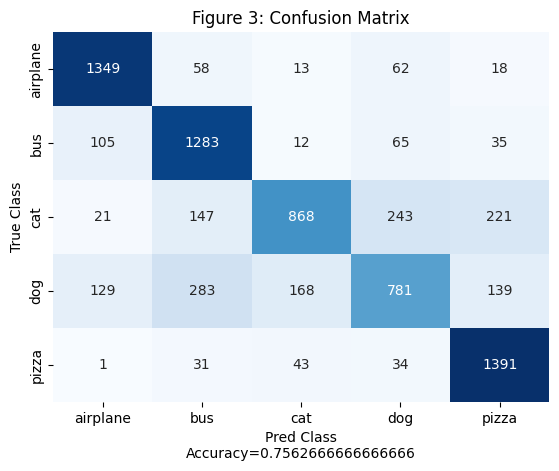

In [15]:
confusion_plot(lab_train, pred_train, 3)
plt.show()

**How does it compare with your CNN based network?**
Net1 in my HW4 achieved an accuracy of 66.4% and achieved around a training loss of around .95 with 7 epochs. 
My ViT achieved an accuracy of 49.8% and a training loss of around 1.2 with 7 epochs. 
So overall it performed worse.
Even after training for 28 epochs (what is shown above), the transformers training loss decreases to around .9 like the hw4 net1 model, but the accuracy is only 50.1%.
It is interesting however, that the training loss continues to decrease with more epochs, but in hw4 seemed to stop making imporvements in loss after 3 epochs.
Despite this decrease in training, the validation accuracy more or less stays the same (instead of getting worse, which would indicate overfitting), this may mean that the capacity of my model is too small. 
Indeed, I only use 4 layers of transformer encoders and an embedding size of 128 and 8 heads (564K parameters).
However the hw1 net1 model had 406K parameters.
The ViT paper used 12 layers and an embedding size of 768 with 12 heads (86M parameters).

## Extra Credit
I wrote my own transformer and used einsum for the multi headed attention. See the Implementation of the Encoder class at the top of the HW